# **Reinforcement Learning: Tarea 1, Estudio comparativo de algoritmos en un problema de k-armed bandit**

## **Autores:** Ana Gil Molina, José María García Ortiz y Levi Malest Villarreal

<br>

**Description:** En esta notebook realizaremos un experimento sobre el *problema del bandido de k brazos* con el que pretendemos comparar el desempeño de distintos algoritmos de la familia *UCB* en base a estadísticos como el porcentaje de elecciones de brazo óptimas y el *regret* acumulado en función del tiempo.

Para poder interpretar los resultados, se incluyen unas gráficas con sus respectivos análisis y conclusiones al final de la sección **[2]** y **[3]**.

<br>

*This software is licensed under the GNU General Public License v3.0 (GPL-3.0),
with the additional restriction that it may not be used for commercial purposes.*

*For more details about GPL-3.0: https://www.gnu.org/licenses/gpl-3.0.html*



## **[1] - Preparación del entorno**


In [ ]:
#@title **Copiar el repositorio** ``JMGO-coding/k_brazos_GGM``.

!git clone https://github.com/JMGO-coding/k_brazos_GGM.git
!cd k_brazos_GGM/

Cloning into 'k_brazos_GGM'...
remote: Enumerating objects: 572, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 572 (delta 45), reused 16 (delta 16), pack-reused 503 (from 1)
Receiving objects: 100% (572/572), 3.92 MiB | 23.35 MiB/s, done.
Resolving deltas: 100% (285/285), done.


In [ ]:
#@title **Importamos todas las clases y funciones**

import sys

# Añadir los directorio fuentes al path de Python
sys.path.append('/content/k_brazos_GGM')
sys.path.append('/content/k_brazos_GGM/src')

# Verificar que se han añadido correctamente
print(sys.path)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List

from algorithms import Algorithm, UCB1, UCB2
from arms import ArmNormal, Bandit, ArmBinomial, ArmBernoulli
from plotting import plot_average_rewards, plot_optimal_selections, plot_arm_statistics, plot_regret

['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython', '/content/k_brazos_GGM', '/content/k_brazos_GGM/src']


## **[2] - Experimento**

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado. Se comparan los resultados de los algoritmos en términos de recompensa promedio.

Por ejemplo. Dado un bandido de k-brazos, se ejecutan varios algoritmos UCB1 y UCB2 con diferentes valores de $\alpha$. Se estudia la evolución de cada política  en un número de pasos, por ejemplo, mil pasos. Entonces se repite el experimento un número de veces, por ejemplo, 500 veces. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso calculamos el promedio de las recompensas obtenidas en esas 500 veces.

In [ ]:
def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):
    """
    Ejecuta experimentos comparativos entre diferentes algoritmos.

    :param bandit: Instancia de Bandit configurada para el experimento.
    :param algorithms: Lista de instancias de algoritmos a comparar.
    :param steps: Número de pasos de tiempo por ejecución.
    :param runs: Número de ejecuciones independientes.
    :return: Tuple de tres elementos: recompensas promedio, porcentaje de selecciones óptimas, y estadísticas de brazos.
    :rtype: Tuple of (np.ndarray, np.ndarray, list)
    """

    k = bandit.k
    optimal_arm = bandit.optimal_arm

    # Inicializar matrices para recompensas y selecciones óptimas
    rewards = np.zeros((len(algorithms), steps))
    optimal_selections = np.zeros((len(algorithms), steps))

    # Inicializar el regret global acumulado por cada algoritmo
    global_cumulative_regret_per_algo = np.zeros((len(algorithms),steps))

    for run in range(runs):
        # Crear una nueva instancia del bandit para cada ejecución
        current_bandit = Bandit(arms=bandit.arms)

        # Obtener la recompensa esperada óptima
        q_max = current_bandit.get_expected_value(current_bandit.optimal_arm)

        for algo in algorithms:
            algo.reset()

        # Inicializar recompensas acumuladas por algoritmo para esta ejecución
        total_rewards_per_algo = np.zeros(len(algorithms))  # Para análisis por rechazo

        # Inicializar recompensas acumuladas por algoritmo para esta ejecución
        # cumulative_rewards_per_algo = np.zeros(len(algorithms))

        num_choices_list = [[0 for _ in range(len(current_bandit.arms))] for _ in algorithms]   # para almacenar un conteo de las selecciones de cada brazo del bandido para cada algoritmo

        rewards_per_arm = np.zeros((len(algorithms), len(current_bandit.arms)))    # para almacenar las recompensas por cada brazo

        # Ejecutar cada algoritmo
        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm()
                reward = current_bandit.pull_arm(chosen_arm)
                algo.update(chosen_arm, reward)

                num_choices_list[idx][chosen_arm] += 1   # Actualizamos el conteo del brazo seleccionado en la estapa correspondiente del algoritmo ``algo``

                rewards[idx, step] += reward
                total_rewards_per_algo[idx] += reward

                rewards_per_arm[idx][chosen_arm] += reward

                global_cumulative_regret_per_algo[idx, step] = q_max*step - total_rewards_per_algo[idx]    # Actualziamos el regret acumulado en cada paso de decisión para cada algoritmo

                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

    # Promediar las recompensas y el regret sobre todas las ejecuciones
    rewards /= runs
    optimal_selections = (optimal_selections / runs) * 100
    cumulative_regret_per_algo = global_cumulative_regret_per_algo.copy()
    #proportional_cumulative_regret_per_algo = global_cumulative_regret_per_algo.copy()
    #proportional_cumulative_regret_per_algo /= runs
    rewards_per_arm /= runs

    return rewards, optimal_selections, num_choices_list, cumulative_regret_per_algo, rewards_per_arm

### **[2.1] - Ejecución del experimento con Distribución Normal**

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución gaussina con desviación 1. Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan un algoritmo UCB1 y 6 algoritmos UCB2 con $\alpha = 0.1, 0.2, 0.3, 0.5, 0.7, 0.9$.

In [ ]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10        # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500    # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k))    # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 1 algoritmo UCB1 y 6 algoritmos UCB2 con diferentes valores de alpha.
algorithms = [UCB1(k=k), UCB2(k=k, alpha = 0.1), UCB2(k=k, alpha = 0.2), UCB2(k=k, alpha = 0.3), UCB2(k=k, alpha = 0.5),
              UCB2(k=k, alpha = 0.7), UCB2(k=k, alpha = 0.9)]

# Extras
optimal_arms_list = [optimal_arm for _ in range(len(algorithms))]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, num_choices_list, proportional_cumulative_regret_per_algo, rewards_per_arm = run_experiment(bandit, algorithms, steps, runs)

# Estadísticas de cada brazo
arm_stats = [{arm: {"media": arm.mu, "std": arm.sigma} for arm in bandit.arms} for _ in range(len(algorithms))]

# Agregar la recompensa por brazo de cada algoritmo en el diccionario correspondiente
for algo_idx in range(len(algorithms)):  # Para cada algoritmo
    for arm_idx, arm in enumerate(bandit.arms):  # Para cada brazo del bandido
        arm_stats[algo_idx][arm]["reward"] = rewards_per_arm[algo_idx][arm_idx]  # Añadir el reward

Bandit with 10 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0)
Optimal arm: 8 with expected reward=9.56


#### **Visualización de los resultados**

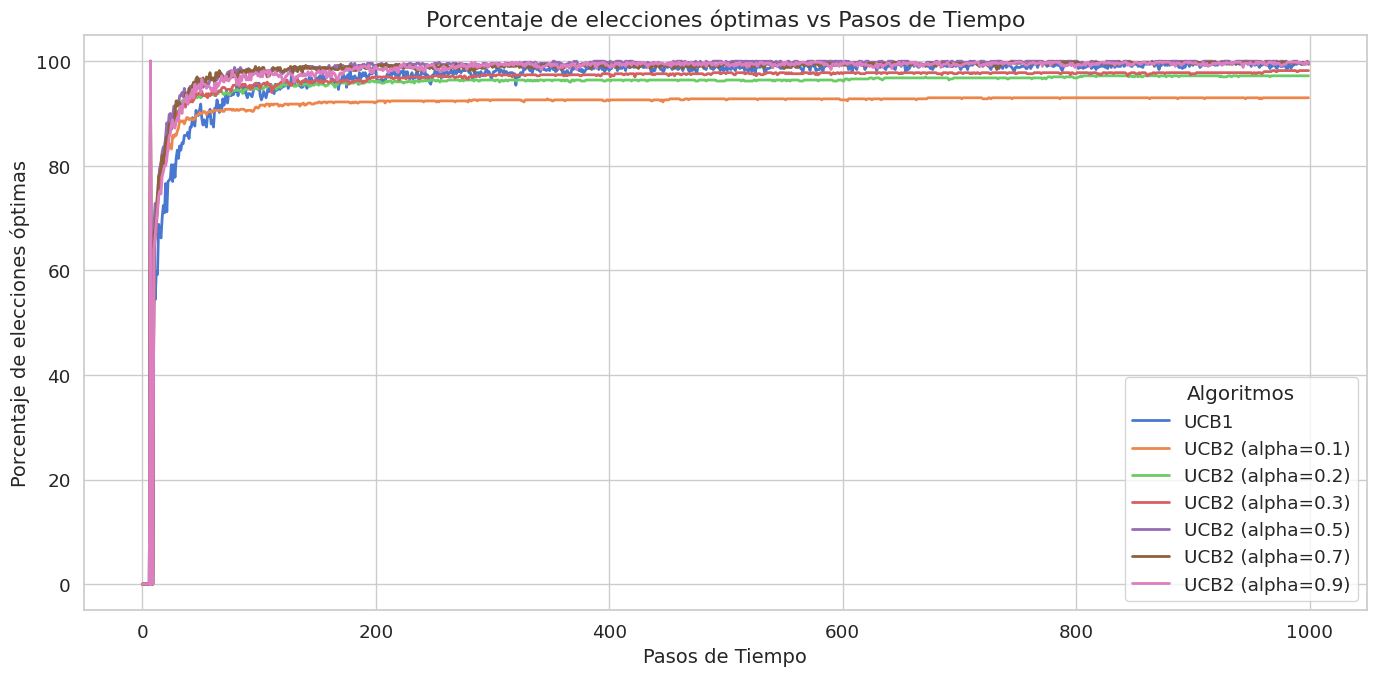

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

#### **Análisis detallado de la imagen (1)**

Esta imagen muestra un gráfico de líneas titulado **"Porcentaje de elecciones óptimas vs Pasos de Tiempo"**, donde se analiza el desempeño de las diferentes estrategias de los algoritmos UCB1 y UCB2 consideradas en un entorno de multi-armed bandit. En este caso, en el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el **porcentaje de elecciones óptimas** obtenido por cada algoritmo.

**Crecimiento del porcentaje de elecciones óptimas:**
  - El algoritmo UCB1 (línea **azul**) muestra un crecimiento del porcentaje de elecciones óptimas algo más lento que los demás algoritmos. Sin embargo,con el paso del tiempo, consigue alcanzar valores bastante elevados.
  - El algoritmo UCB2 con **$\alpha=0.1$** (línea **naranja**) muestra un crecimiento del porcentaje de elecciones óptimas más rápido que UCB1, pero converge en un valor inferior al de UCB1.
  - El algoritmo UCB2 con **$\alpha=0.2$** (línea **verde**) también muestra un crecimiento rápido desde el principio, y consigue alcanzar un valor mayor del porcentaje de elecciones óptimas que UCB2 con $\alpha=0.1$. Esto es debido a que valores más bajos de $\alpha$ priorizan más la explotación de forma más rápida. Sin embargo, se sigue quedando por debajo del valor alcanzado con UCB1.
  - El algoritmo UCB2 con **$\alpha=0.3$** (línea **roja**) también muestra un crecimiento rápido desde el principio, y se estabiliza en un valor mayor del porcentaje de elecciones óptimas que UCB2 con $\alpha=0.2$. Esto ocurre de nuevo porque al aumentar $\alpha$ se permite una mayor exploración mientras se sigue explotando el brazo óptimo. Sin embargo, todavía se sigue quedando por debajo del valor alcanzado con UCB1.
  - El algoritmo UCB2 con **$\alpha=0.5$** (línea **morada**) crece bastante rápido desde el principio, y consigue alcanzar un valor más elevado que los casos anteriores, consiguiendo incluso superar ligeramente a UCB1. Con este valor de $\alpha$ se consigue un balance eficiente entre exploración y explotación.
  - El algoritmo UCB2 con **$\alpha=0.7$** (línea **marrón**) muestra un rendimiento muy similar al UCB2 con $\alpha=0.5$, aunque ligeramente inferior. Podría deberse a que $\alpha = 0.7$ favorece una exploración más prolongada, retrasando la explotación del mejor brazo por más tiempo.
  - El algoritmo UCB2 con **$\alpha=0.9$** (línea **rosa**) también crece bastante rápido al principio, pero alcanza valores algo menores a los de los dos casos anteriores. Esto probablemente se debe a que la exploración es demasiado prolongada, retrasando la explotación óptima de los mejores brazos.

Esta diferencia entre el rendimiento de los algoritmos UCB1 y UCB2 podría deberse a que UCB1 utiliza una fórmula más sencilla para balancear exploración y explotación, basada en el número total de acciones $t$, y el número de veces que el brazo $a$ ha sido seleccionada $N(a)$:

$$ UCB1(a) = Q(a) + c \times \sqrt{\frac{\ln t}{N(a)}}$$

donde tomamos $c=\sqrt{2}$. Así, UCB1 tiende a explorar más cuando un brazo ha sido seleccionado menos veces (menor $N(a)$). Además, la exploración disminuye lentamente con el tiempo porque el término $c \times \sqrt{\frac{\ln t}{N(a)}}$ disminuye más lentamente a medida que se acumulan más pasos.
  
Sin embargo, el algoritmo UCB2 mejora esta estrategia gracias a la fórmula:

$$ UCB2(a) = Q(a) + \sqrt{\frac{(1+\alpha)\ln t}{2\tau(k_a)}}$$

donde $Q(a)$ es la estimación del valor de la acción $a$, $0<\alpha<1$ es un parámetro de ajuste para el balance entre exploración y explotación, $k_a$ es el número de épocas de la acción $a$, y $\tau(k_a) = \lceil (1+\alpha)^{k_a}\rceil$ determina el número de veces que la acción $a$ será seleccionada en una época. Gracias a $\tau(k_a)$, la exploración se vuelve más eficiente, ya que no solo depende de cuántas veces se ha seleccionado el brazo $a$, sino también de las épocas. De esta forma, la actualización de la exploración es más dinámica, pues se ajusta con el número de épocas, permitiendo que el algoritmo converja más rápido.

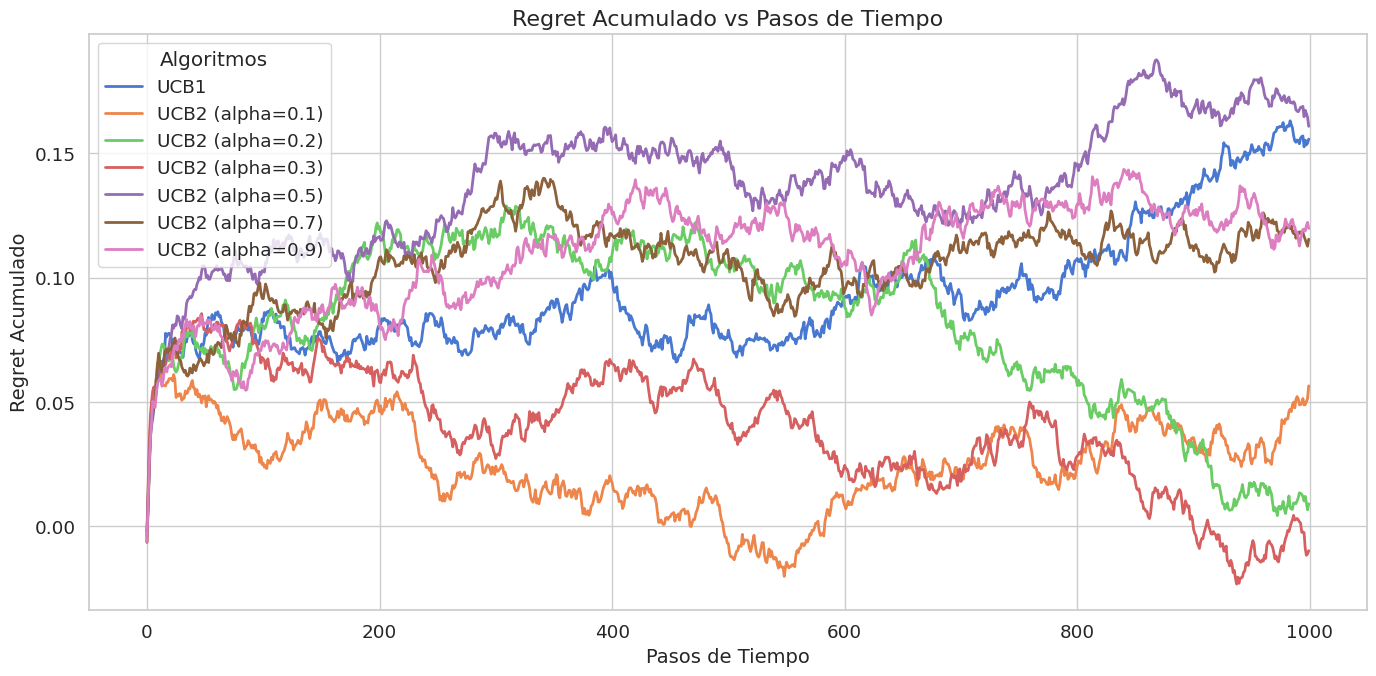

In [ ]:
plot_regret(steps, regret_accumulated=proportional_cumulative_regret_per_algo, algorithms = algorithms)

#### **Análisis detallado de la imagen (2)**

Esta imagen muestra un gráfico de líneas titulado **"Regret acumulado vs Pasos de Tiempo"**, donde en el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el **regret acumulado** obtenido por cada algoritmo **UCB** considerado.

**Crecimiento del regret acumulado a lo largo del tiempo:**
  - Los algoritmos UCB1 (línea **azul**), UCB2 con **$\alpha=0.5$** (línea **morada**), UCB2 con **$\alpha=0.7$** (línea **marrón**) y UCB2 con **$\alpha=0.9$** (línea **rosa**) muestran el peor desempeño, pues se observa que el regret tiene una tendencia a crecer con el tiempo, y con valores mayores que los otros algoritmos. Esto podría deberse a que valores más elevados de $\alpha$ (o en el caso de UCB1, debido a su estrategia de exploración) favorecen la exploración durante más tiempo, haciendo que el algoritmo siga probando brazos subóptimos a lo largo del tiempo, incrementando el regret acumulado.
  - Los algoritmos UCB2 con **$\alpha=0.1$** (línea **naranja**), UCB2 con **$\alpha=0.2$** (línea **verde**) y UCB2 con **$\alpha=0.3$** (línea **roja**) muestran un desempeño algo mejor. El regret aumenta al principio, especialmente para $\alpha = 0.2$, pero después su crecimiento se vuelve más lento, llegando incluso a decrecer el regret en los últimos pasos. En este caso, parece que los algoritmos logran identificar el brazo óptimo, explotándolo una vez encontrado, haciendo que el regret acumulado se estabilice en los últimos pasos.

En general, con todos los algoritmos, el regret acumulado es bastante bajo, inferior en todos los casos al $0.2$, lo cual indica que los métodos UCB tienen un buen desempeño en el problema.

#### **Observación**

En teoría, el regret esperado es no decreciente:

$$ \mathbb{E}[R_T] = q^*T - \sum_{t=1}^T \mathbb{E}(r_t) $$

con $q^* = \max_{a\in A} q(a)$. Esto se debe a que en su definición, se considera la esperanza de las recompensas obtenidas, que corresponde a la media de las distribuciones de los brazos. Dado que esta media es fija, el regret acumulado solo puede mantenerse o aumentar con el tiempo.

Sin embargo, en nuestro caso estamos trabajando con el regret experimental:

$$ R_T = q^*T - \sum_{t=1}^T r_t $$

Este se calcula a partir de las recompensas concretas obtenidas en cada ejecución. Dado que las recompensas se muestrean de una distribución normal con varianza, puede haber situaciones en las que el valor obtenido en un paso sea mayor que la media esperada. En particular, si en un paso $T$ se obtiene una recompensa atípicamente alta, la diferencia entre la recompensa óptima acumulada y la recompensa obtenida hasta ese paso puede reducirse en comparación con el paso $T-1$. Como consecuencia, el regret acumulado en $T$ podría ser menor que en $T-1$, haciendo que este disminuya ligeramente en el tiempo.

Ahora pasamos a volver a mostrar el mismo gráfico, pero esta vez añadiendo la cota teórica para el regret, de forma que podamos comprobar si los regret acumulados obtenidos se mantienen por debajo de dicha cota.

Según Lai y Robbins, bajo ciertas condiciones se cumple:

$$ \liminf_{T\rightarrow \infty} \frac{\sum_{i:\mu_i < \mu^*}(\mu^* - \mu_i) E[n_i]}{ln(T)} \geq \sum_{i:\mu_i < \mu^*}\frac{\mu^* - \mu_i}{I(\mu_i, \mu^*)} = Cte $$

- El numerador es $L_T$: $q^* = \mu^*$, $q(a_i)=\mu_i$, $E[n_i] = E[N_T(a_i)]$
- Consecuencia: $L_T\geq Cte\cdot \ln(T)$
- Divergencia de Kullback-Leibler: $I(\mu_i, \mu^*) = \displaystyle \int_{-\infty}^{+\infty}\log\left(\frac{p_i(x)}{p^*(x)}\right)p_j(x)\,dx$
- Con distribución normal: $I(\mu_i, \mu^*) = \frac{(\mu_i - \mu^*)^2}{2\sigma^2}$

In [ ]:
def I_normal(mu_i, mu_star, sigma_2):
    """Divergencia KL entre dos normales con la misma varianza."""
    return (mu_i - mu_star)**2 / (2 * sigma_2)

mus = [bandit.get_expected_value(num_arm) for num_arm in range(len(bandit.arms))]    # Medias de los brazos
mu_star = max(mus)   # Media del brazo óptimo
sigma_2 = 1          # Varianza de los brazos (igual para todos)

# Calcular la constante
cte = sum((mu_star - mu) / I_normal(mu, mu_star, sigma_2) for mu in mus if mu < mu_star)

# Cota teórica
theoretical_bound = cte * np.array([np.log(step) for step in range(steps)])

<ipython-input-13-8354763144da>:13: RuntimeWarning: divide by zero encountered in log
  theoretical_bound = cte * np.array([np.log(step) for step in range(steps)])


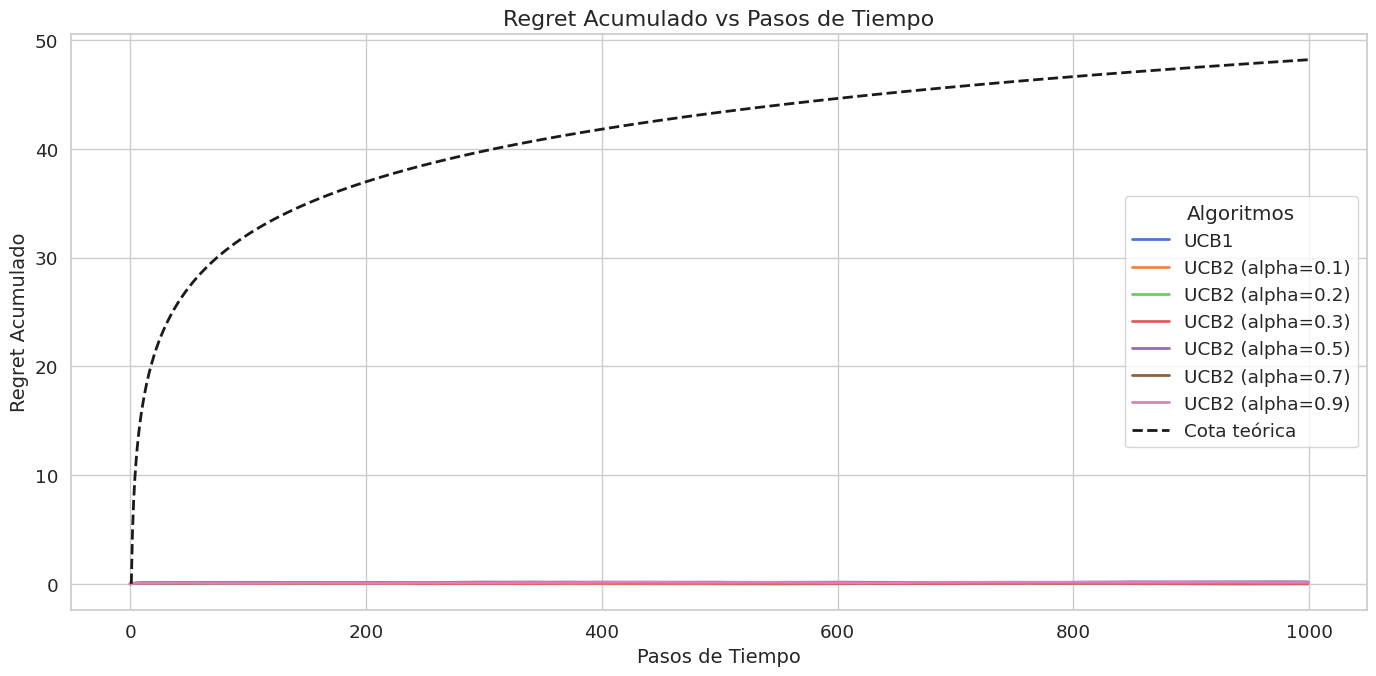

In [ ]:
plot_regret(steps, regret_accumulated=proportional_cumulative_regret_per_algo, algorithms = algorithms, theoretical_bound = theoretical_bound)

Efectivamente, el regret acumulado se mantiene muy por debajo de la cota teórica con todos los algoritmos UCB considerados, mostrando el buen desempeño de dichos algoritmos.

### **[2.2] - Ejecución del experimento con Distribución Bernoulli**

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución Bernoulli. Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan un algoritmo UCB1 y 6 algoritmos UCB2 con $\alpha = 0.1, 0.2, 0.3, 0.5, 0.7, 0.9$.

In [ ]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10        # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500    # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBernoulli.generate_arms(k))    # Generar un bandido con k brazos de distribución Bernoulli
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 1 algoritmo UCB1 y 6 algoritmos UCB2 con diferentes valores de alpha.
algorithms = [UCB1(k=k), UCB2(k=k, alpha = 0.1), UCB2(k=k, alpha = 0.2), UCB2(k=k, alpha = 0.3), UCB2(k=k, alpha = 0.5),
              UCB2(k=k, alpha = 0.7), UCB2(k=k, alpha = 0.9)]

# Extras
optimal_arms_list = [optimal_arm for _ in range(len(algorithms))]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, num_choices_list, proportional_cumulative_regret_per_algo, rewards_per_arm = run_experiment(bandit, algorithms, steps, runs)

# Estadísticas de cada brazo
arm_stats = [{arm: {"media": arm.mu} for arm in bandit.arms} for _ in range(len(algorithms))]

# Agregar la recompensa por brazo de cada algoritmo en el diccionario correspondiente
for algo_idx in range(len(algorithms)):  # Para cada algoritmo
    for arm_idx, arm in enumerate(bandit.arms):  # Para cada brazo del bandido
        arm_stats[algo_idx][arm]["reward"] = rewards_per_arm[algo_idx][arm_idx]  # Añadir el reward

Bandit with 10 arms: ArmBernoulli(p=0.3745401188473625), ArmBernoulli(p=0.9507143064099162), ArmBernoulli(p=0.7319939418114051), ArmBernoulli(p=0.5986584841970366), ArmBernoulli(p=0.15601864044243652), ArmBernoulli(p=0.15599452033620265), ArmBernoulli(p=0.05808361216819946), ArmBernoulli(p=0.8661761457749352), ArmBernoulli(p=0.6011150117432088), ArmBernoulli(p=0.7080725777960455)
Optimal arm: 2 with expected reward=0.9507143064099162


#### **Visualización de los resultados**

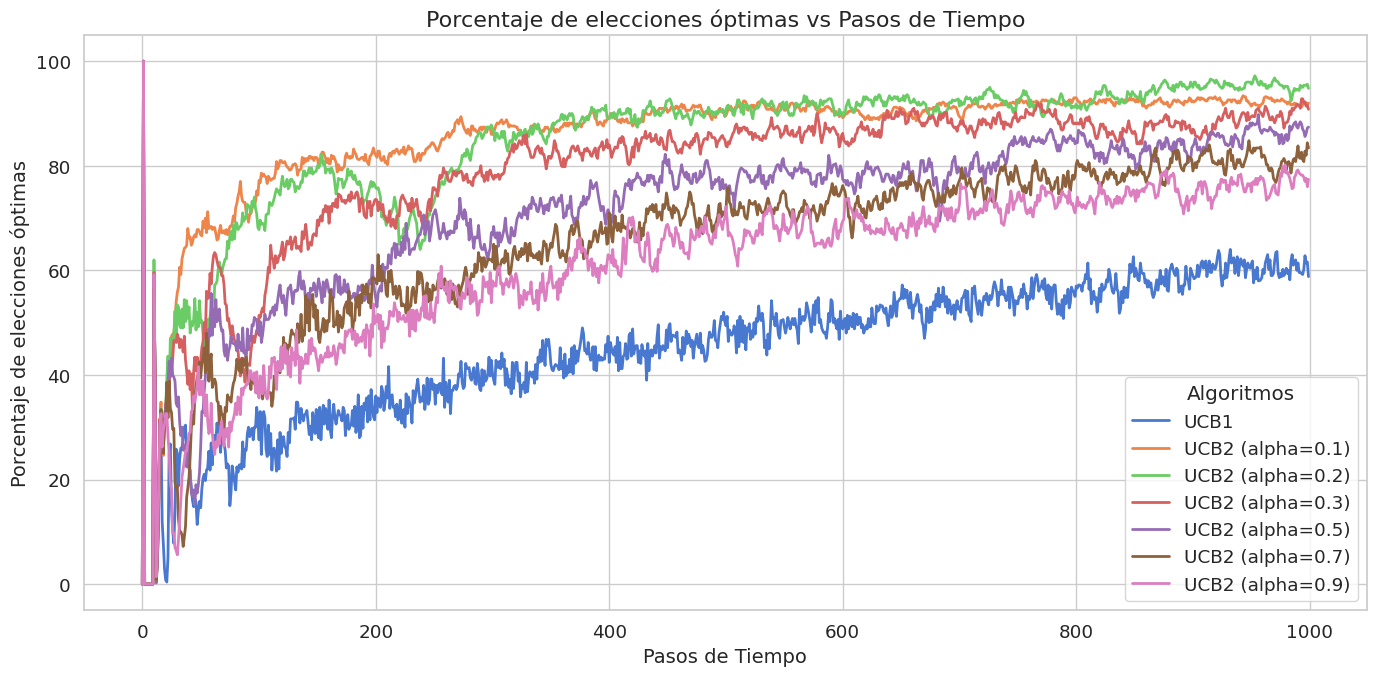

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

#### **Análisis detallado de la imagen (1)**

Esta imagen muestra un gráfico de líneas titulado **"Porcentaje de elecciones óptimas vs Pasos de Tiempo"**, donde se analiza el desempeño de las diferentes estrategias de los algoritmos UCB1 y UCB2 consideradas en un entorno de multi-armed bandit. En este caso, en el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el **porcentaje de elecciones óptimas** obtenido por cada algoritmo.

**Crecimiento del porcentaje de elecciones óptimas:**
  - El algoritmo UCB1 (línea **azul**) muestra un crecimiento del porcentaje de elecciones óptimas más lento que los demás algoritmos. Además, los valores que logra alcanzar son bastante bajos en comparación con el resto de algoritmos.
  - El algoritmo UCB2 con **$\alpha=0.1$** (línea **naranja**) muestra un muy buen desempeño del porcentaje de elecciones óptimas, creciendo rápidamente  al principio, y estabilizándose en un valor bastante alto.
  - El algoritmo UCB2 con **$\alpha=0.2$** (línea **verde**) también muestra un crecimiento rápido desde el principio, aunque ligeramente más lento que con $\alpha=0.1$. Sin embargo, con el paso del tiempo consigue alcanzar un valor mayor del porcentaje de elecciones óptimas que UCB2 con $\alpha=0.1$.
  - El algoritmo UCB2 con **$\alpha=0.3$** (línea **roja**) también muestra un crecimiento rápido desde el principio, aunque se estabiliza en un valor algo inferior que los dos casos anteriores. Esto ocurre porque al aumentar $\alpha$ se permite una mayor exploración, y puede que en este caso no sea necesaria tanta exploración.
  - Los algoritmos UCB2 con **$\alpha=0.5$** (línea **morada**), UCB2 con **$\alpha=0.7$** (línea **marrón**) y UCB2 con **$\alpha=0.9$** (línea **rosa**) van mostrando cada vez un peor rendimiento al ir aumentando el valor de $\alpha$, mostrando que efectivamente, al permitir una mayor exploración, los resultados empeoran.


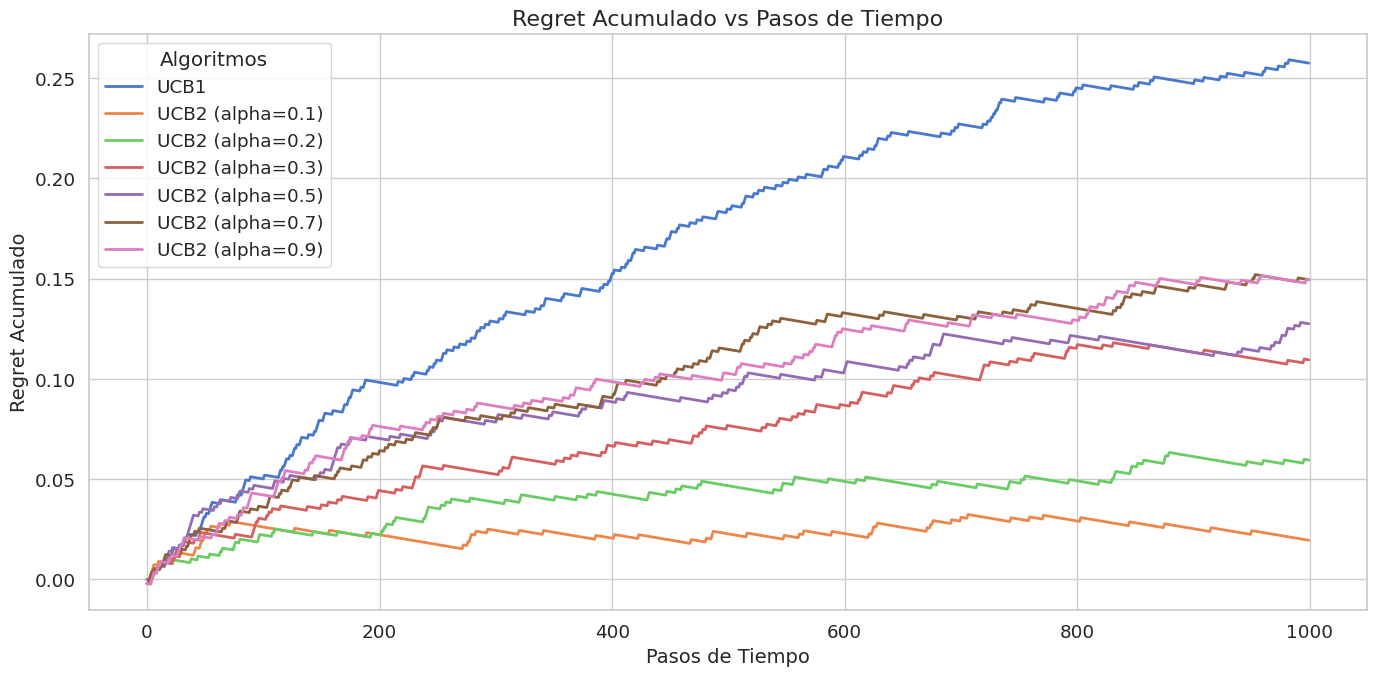

In [ ]:
plot_regret(steps, regret_accumulated=proportional_cumulative_regret_per_algo, algorithms = algorithms)

#### **Análisis detallado de la imagen (2)**

Esta imagen muestra un gráfico de líneas titulado **"Regret acumulado vs Pasos de Tiempo"**, donde en el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el **regret acumulado** obtenido por cada algoritmo **UCB** considerado.

**Crecimiento del regret acumulado a lo largo del tiempo:**
  - El algoritmo UCB1 (línea **azul**) es el que muestra el peor desempeño de todos para el regret acumulado, probablemente debido a que no es capaz de balancear de forma tan eficiente como UCB2 entre exploración y explotación.
  - Los algoritmos UCB2 con **$\alpha=0.3$** (línea **roja**), UCB2 con **$\alpha=0.5$** (línea **morada**), UCB2 con **$\alpha=0.7$** (línea **marrón**) y UCB2 con **$\alpha=0.9$** (línea **rosa**) tienen un regret acumulado inferior a UCB1, pero igualmente se observa que el regret con estos algoritmos tiene una tendencia a crecer con el tiempo, y con valores mayores que los otros algoritmos UCB2. Esto podría deberse a que valores más elevados de $\alpha$ favorecen la exploración durante más tiempo, haciendo que el algoritmo siga probando brazos subóptimos a lo largo del tiempo, incrementando el regret acumulado.
  - Los algoritmos UCB2 con **$\alpha=0.1$** (línea **naranja**) y UCB2 con **$\alpha=0.2$** (línea **verde**) muestran el mejor desempeño. El regret logra mantenerse en valores realmente bajos, especialmente para $\alpha=0.1$, indicando que una menor exploración es conveniente en este problema. Parece que los algoritmos logran identificar el brazo óptimo rápidamente, explotándolo y haciendo que el regret acumulado se estabilice.


Ahora pasamos a volver a mostrar el mismo gráfico, pero esta vez añadiendo la cota teórica para el regret, de forma que podamos comprobar si los regret acumulados obtenidos se mantienen por debajo de dicha cota.

Según Lai y Robbins, bajo ciertas condiciones se cumple:

$$ \liminf_{T\rightarrow \infty} \frac{\sum_{i:\mu_i < \mu^*}(\mu^* - \mu_i) E[n_i]}{ln(T)} \geq \sum_{i:\mu_i < \mu^*}\frac{\mu^* - \mu_i}{I(\mu_i, \mu^*)} = Cte $$

- El numerador es $L_T$: $q^* = \mu^*$, $q(a_i)=\mu_i$, $E[n_i] = E[N_T(a_i)]$
- Consecuencia: $L_T\geq Cte\cdot \ln(T)$
- Divergencia de Kullback-Leibler: $I(\mu_i, \mu^*) = \displaystyle \int_{-\infty}^{+\infty}\log\left(\frac{p_i(x)}{p^*(x)}\right)p_j(x)\,dx$
- Con distribución normal: $I(\mu_i, \mu^*) = \mu_i \ln \left( \frac{\mu_i}{\mu^*} \right) + (1 - \mu_i) \ln \left( \frac{1 - \mu_i}{1 - \mu^*} \right)$

In [ ]:
def I_bernoulli(mu_i, mu_star):
    """Divergencia KL entre dos Bernoulli."""
    return mu_i * np.log(mu_i / mu_star) + (1 - mu_i) * np.log((1 - mu_i) / (1 - mu_star))

mus = [bandit.get_expected_value(num_arm) for num_arm in range(len(bandit.arms))]    # Medias de los brazos
mu_star = max(mus)   # Media del brazo óptimo

# Calcular la constante
cte = sum((mu_star - mu) / I_bernoulli(mu, mu_star) for mu in mus if mu < mu_star)

# Cota teórica
theoretical_bound = cte * np.array([np.log(step) for step in range(steps)])

<ipython-input-13-14c133996bdd>:12: RuntimeWarning: divide by zero encountered in log
  theoretical_bound = cte * np.array([np.log(step) for step in range(steps)])


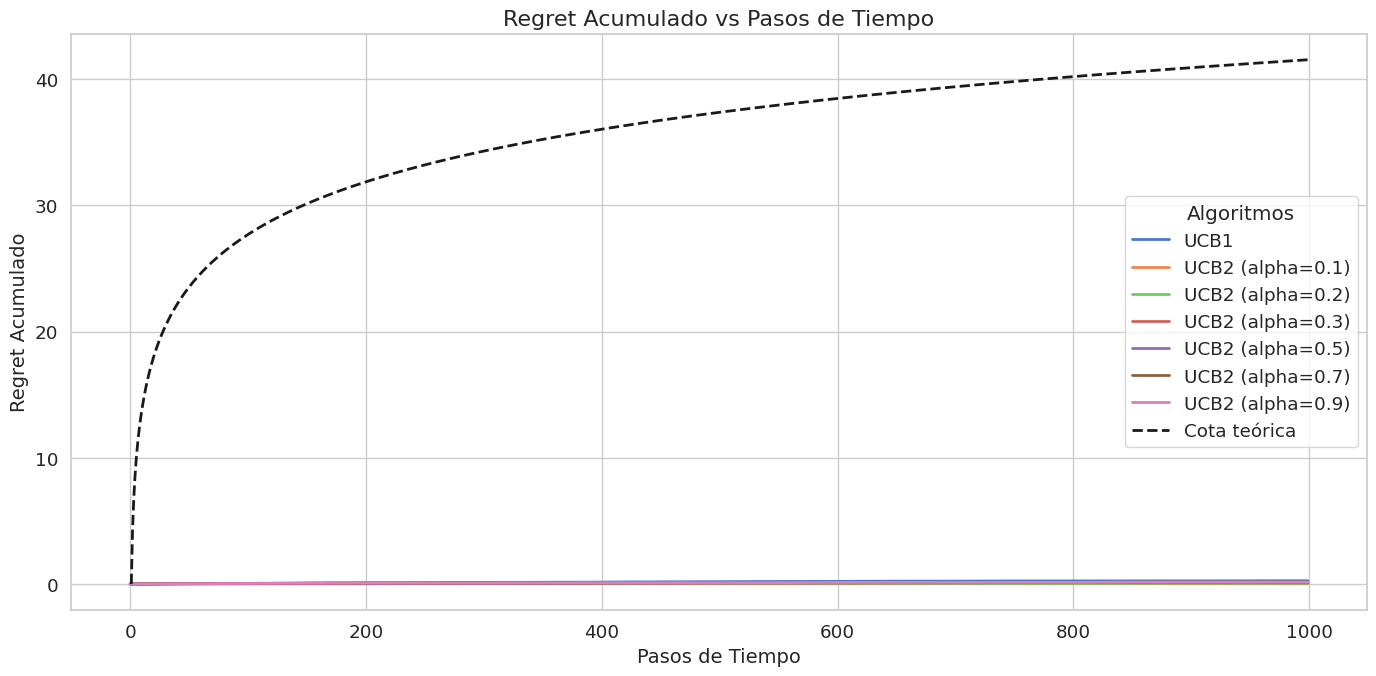

In [ ]:
plot_regret(steps, regret_accumulated=proportional_cumulative_regret_per_algo, algorithms = algorithms, theoretical_bound = theoretical_bound)

De nuevo, el regret acumulado se mantiene muy por debajo de la cota teórica con todos los algoritmos UCB considerados, mostrando el buen desempeño de dichos algoritmos.

### **[2.3] - Ejecución del experimento con Distribución Binomial**

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución Binomial. Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan un algoritmo UCB1 y 6 algoritmos UCB2 con $\alpha = 0.1, 0.2, 0.3, 0.5, 0.7, 0.9$.

In [ ]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10        # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500    # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBinomial.generate_arms(k))    # Generar un bandido con k brazos de distribución Binomial
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 1 algoritmo UCB1 y 6 algoritmos UCB2 con diferentes valores de alpha.
algorithms = [UCB1(k=k), UCB2(k=k, alpha = 0.1), UCB2(k=k, alpha = 0.2), UCB2(k=k, alpha = 0.3), UCB2(k=k, alpha = 0.5),
              UCB2(k=k, alpha = 0.7), UCB2(k=k, alpha = 0.9)]

# Extras
optimal_arms_list = [optimal_arm for _ in range(len(algorithms))]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, num_choices_list, proportional_cumulative_regret_per_algo, rewards_per_arm = run_experiment(bandit, algorithms, steps, runs)

# Estadísticas de cada brazo
arm_stats = [{arm: {"media": arm.mu} for arm in bandit.arms} for _ in range(len(algorithms))]

# Agregar la recompensa por brazo de cada algoritmo en el diccionario correspondiente
for algo_idx in range(len(algorithms)):  # Para cada algoritmo
    for arm_idx, arm in enumerate(bandit.arms):  # Para cada brazo del bandido
        arm_stats[algo_idx][arm]["reward"] = rewards_per_arm[algo_idx][arm_idx]  # Añadir el reward

Bandit with 10 arms: ArmBinomial(n=20, p=0.21233911067827616), ArmBinomial(n=2, p=0.8661761457749352), ArmBinomial(n=9, p=0.9507143064099162), ArmBinomial(n=8, p=0.5247564316322378), ArmBinomial(n=5, p=0.18340450985343382), ArmBinomial(n=15, p=0.7080725777960455), ArmBinomial(n=1, p=0.9699098521619943), ArmBinomial(n=11, p=0.2912291401980419), ArmBinomial(n=18, p=0.5986584841970366), ArmBinomial(n=4, p=0.15599452033620265)
Optimal arm: 9 with expected reward=10.775852715546659


#### **Visualización de los resultados**

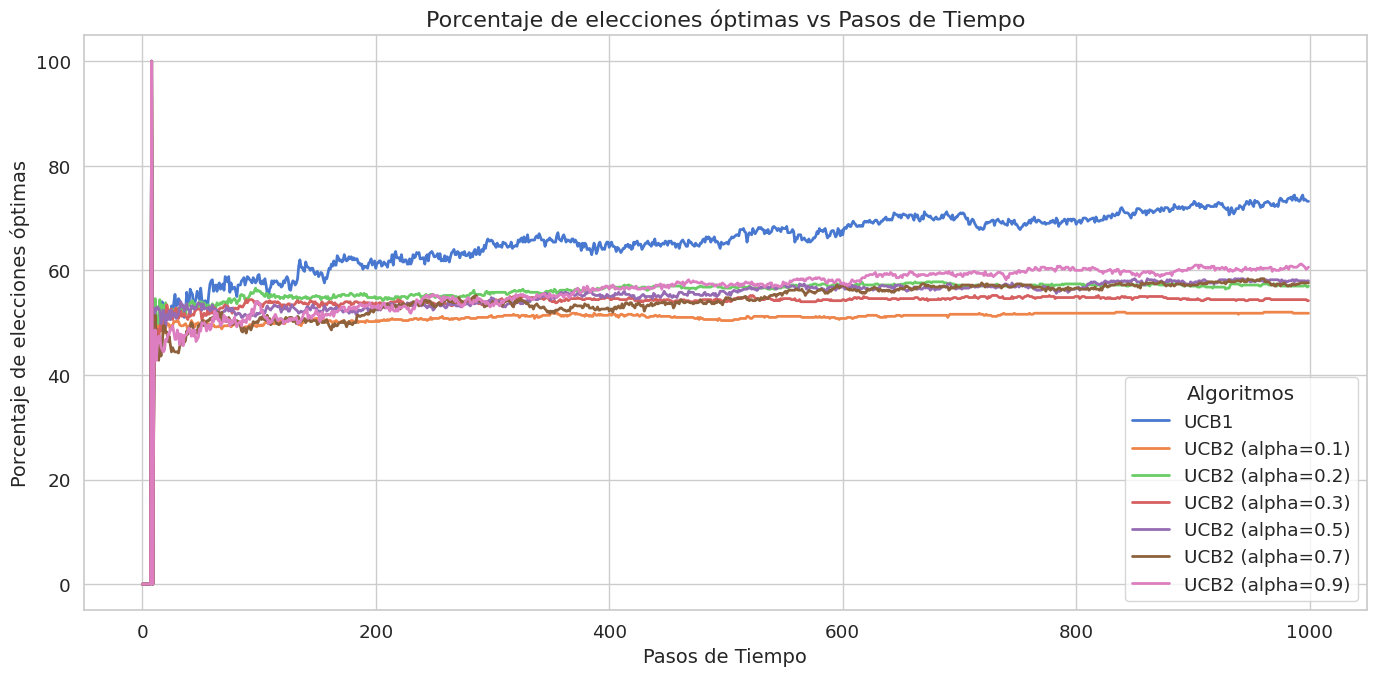

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

#### **Análisis detallado de la imagen (1)**

Esta imagen muestra un gráfico de líneas titulado **"Porcentaje de elecciones óptimas vs Pasos de Tiempo"**, donde se analiza el desempeño de las diferentes estrategias de los algoritmos UCB1 y UCB2 consideradas en un entorno de multi-armed bandit. En este caso, en el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el **porcentaje de elecciones óptimas** obtenido por cada algoritmo.

**Crecimiento del porcentaje de elecciones óptimas:**
  - El algoritmo UCB1 (línea **azul**) muestra el mejor desempeño en términos de elecciones óptimas. Esto puede deberse a que con distribución normal, la incertidumbre en la probabilidad de éxito es significativa en las primeras etapas, y el algoritmo se ajusta gradualmente conforme va adquiriendo experiencia.
  - Los algoritmos UCB2 con **$\alpha=0.1$** (línea **naranja**), UCB2 con **$\alpha=0.2$** (línea **verde**), UCB2 con **$\alpha=0.3$** (línea **roja**), UCB2 con **$\alpha=0.5$** (línea **morada**), UCB2 con **$\alpha=0.7$** (línea **marrón**) y UCB2 con **$\alpha=0.9$** (línea **rosa**) muestran un peor rendimiento que UCB1. Además, entre ellos están bastante igualados, con un porcentaje ligeramente mayor con $\alpha=0.9$, y menor con $\alpha=0.1$ y $\alpha=0.3$. Esto es, van mostrando un rendimiento ligeramente mejor al ir aumentando el valor de $\alpha$, mostrando que al permitir una mayor exploración, los resultados mejoran. En una distribución binomial, favorecer la explotación desde el principio con un $\alpha$ bajo puede no ser efectivo al principio, porque el algoritmo puede no tener suficiente información para tomar decisiones óptimas rápidamente.

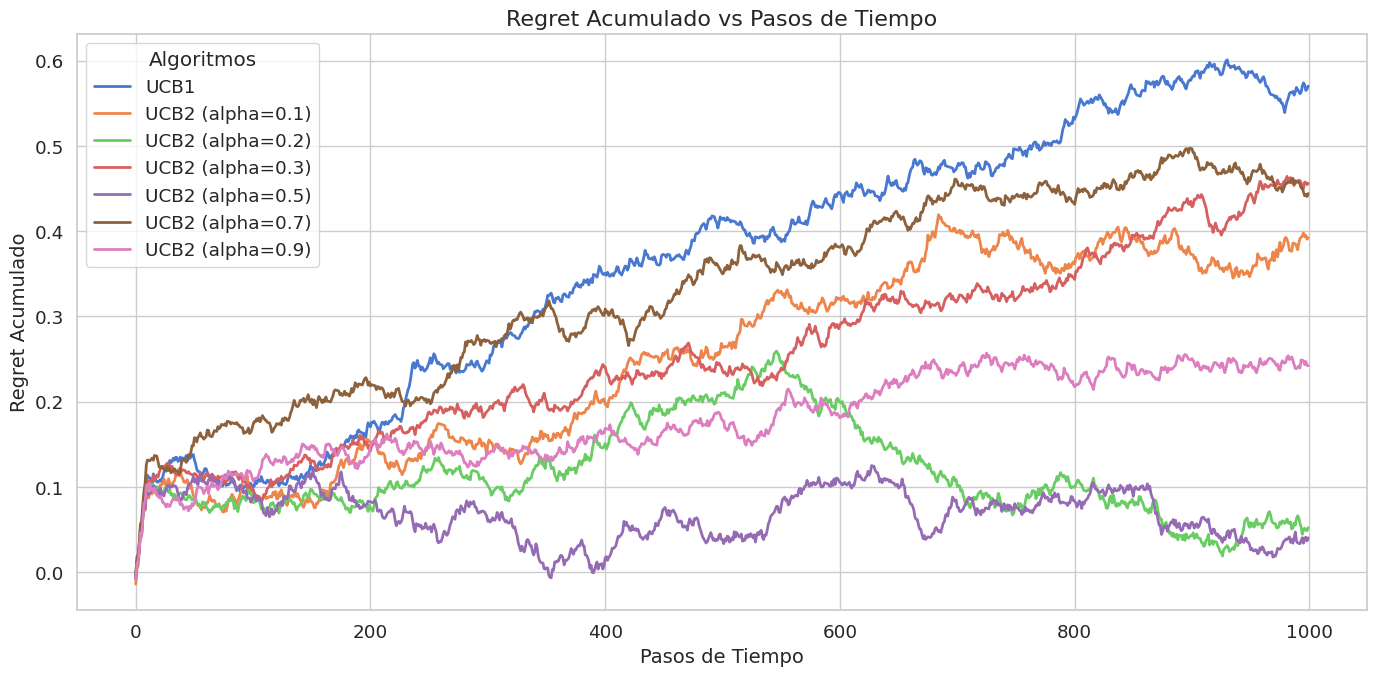

In [ ]:
plot_regret(steps, regret_accumulated=proportional_cumulative_regret_per_algo, algorithms = algorithms)

#### **Análisis detallado de la imagen (2)**

Esta imagen muestra un gráfico de líneas titulado **"Regret acumulado vs Pasos de Tiempo"**, donde en el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el **regret acumulado** obtenido por cada algoritmo **UCB** considerado.

**Crecimiento del regret acumulado a lo largo del tiempo:**
  - El algoritmo UCB1 (línea **azul**) es el que muestra el peor desempeño de todos para el regret acumulado, probablemente debido a que no es capaz de balancear de forma tan eficiente como UCB2 entre exploración y explotación, pues tiene una estrategia más estática de balance.
  - Los algoritmos UCB2 con **$\alpha=0.1$** (línea **naranja**), UCB2 con **$\alpha=0.3$** (línea **roja**) y UCB2 con **$\alpha=0.7$** (línea **marrón**) tienen un regret acumulado inferior a UCB1, pero igualmente se observa que el regret con estos algoritmos tiene una tendencia a crecer con el tiempo, y con valores mayores que los otros algoritmos UCB2. Esto podría deberse a que valores más elevados de $\alpha$ favorecen la exploración durante más tiempo, haciendo que el algoritmo siga probando brazos subóptimos a lo largo del tiempo, incrementando el regret acumulado.
  - El algoritmo  UCB2 con **$\alpha=0.9$** (línea **rosa**) muestra un desempeño mejor que los anteriores con el regret acumulado, probablemente porque se centra más en la explotación. Sin embargo, los resultados que obtiene tampoco son los mejores, tal vez porque tarda en encontrar el brazo óptimo.
  - Los algoritmos UCB2 con **$\alpha=0.2$** (línea **verde**) y UCB2 con **$\alpha=0.5$** (línea **morada**) muestran el mejor desempeño. El regret logra mantenerse en valores bastante bajos, especialmente para $\alpha=0.5$, probablemente porque consigue un buen balance entre exploración y explotación. Sin embargo, no parece haber un patrón claro que indique por qué estos dos valores de $\alpha$ son los que mejores resultados dan para el regret acumulado, lo que podría estar relacionado con la semilla seleccionada o con los datos específicos usados en este experimento.


Ahora pasamos a volver a mostrar el mismo gráfico, pero esta vez añadiendo la cota teórica para el regret, de forma que podamos comprobar si los regret acumulados obtenidos se mantienen por debajo de dicha cota.

Según Lai y Robbins, bajo ciertas condiciones se cumple:

$$ \liminf_{T\rightarrow \infty} \frac{\sum_{i:\mu_i < \mu^*}(\mu^* - \mu_i) E[n_i]}{ln(T)} \geq \sum_{i:\mu_i < \mu^*}\frac{\mu^* - \mu_i}{I(\mu_i, \mu^*)} = Cte $$

- El numerador es $L_T$: $q^* = \mu^*$, $q(a_i)=\mu_i$, $E[n_i] = E[N_T(a_i)]$
- Consecuencia: $L_T\geq Cte\cdot \ln(T)$
- Divergencia de Kullback-Leibler: $I(\mu_i, \mu^*) = \displaystyle \int_{-\infty}^{+\infty}\log\left(\frac{p_i(x)}{p^*(x)}\right)p_j(x)\,dx$
- Con distribución binomial: $I(p_i, p^*) = n_i \left[ p_i \ln \left( \frac{p_i}{p^*} \right) + (1 - p_i) \ln \left( \frac{1 - p_i}{1 - p^*} \right) \right] + n^* \left[ p^* \ln \left( \frac{p^*}{p_i} \right) + (1 - p^*) \ln \left( \frac{1 - p^*}{1 - p_i} \right) \right]$

In [ ]:
def I_binomial(n_i, n_star, p_i, p_star):
    """Divergencia KL entre dos Binomiales B(n_i, p_i) y B(n_star, p_star)."""
    term1 = n_i * (p_i * np.log(p_i / p_star) + (1 - p_i) * np.log((1 - p_i) / (1 - p_star)))
    term2 = n_star * (p_star * np.log(p_star / p_i) + (1 - p_star) * np.log((1 - p_star) / (1 - p_i)))

    return term1 + term2

mus = [bandit.get_expected_value(num_arm) for num_arm in range(len(bandit.arms))]    # Medias de los brazos
mu_star = max(mus)   # Media del brazo óptimo
ns = [arm.n for arm in bandit.arms]
n_star = max(ns)
ps = [arm.p for arm in bandit.arms]
p_star = max(ps)

# Calcular la constante
cte = sum((mu_star - mus[i]) / I_binomial(ns[i], n_star, ps[i], p_star) for i in range(len(mus)) if mus[i] < mu_star)

# Cota teórica
theoretical_bound = cte * np.array([np.log(step) for step in range(steps)])

<ipython-input-24-f6fc6e262db1>:16: RuntimeWarning: divide by zero encountered in scalar divide
  cte = sum((mu_star - mus[i]) / I_binomial(ns[i], n_star, ps[i], p_star) for i in range(len(mus)) if mus[i] < mu_star)
<ipython-input-24-f6fc6e262db1>:19: RuntimeWarning: divide by zero encountered in log
  theoretical_bound = cte * np.array([np.log(step) for step in range(steps)])
<ipython-input-24-f6fc6e262db1>:19: RuntimeWarning: invalid value encountered in multiply
  theoretical_bound = cte * np.array([np.log(step) for step in range(steps)])


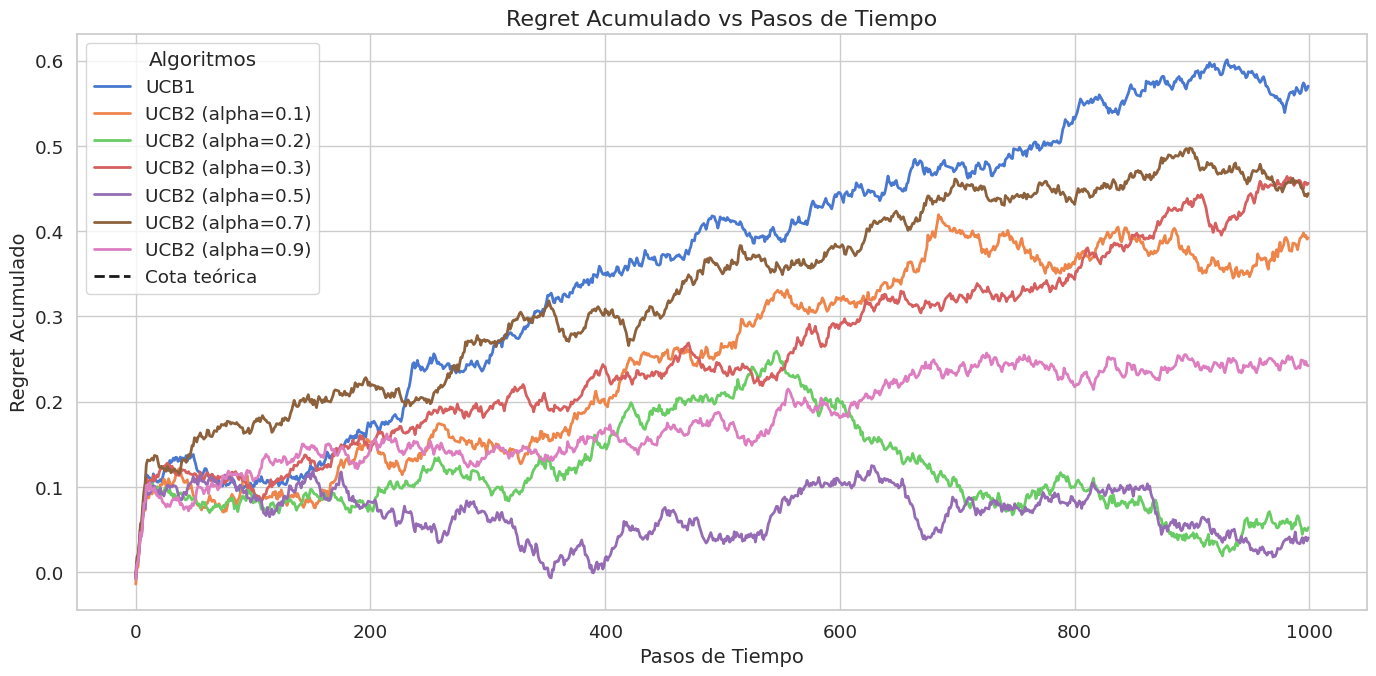

In [ ]:
plot_regret(steps, regret_accumulated=proportional_cumulative_regret_per_algo, algorithms = algorithms, theoretical_bound = theoretical_bound)

In [ ]:
theoretical_bound

array([-inf,  nan,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  i

La cota teórica sale infinito, por lo que en cualquier caso, el regret acumulado obtenido por cualquiera de los algoritmos va a estar por debajo de esta cota.

## **[3] - Conclusiones de este estudio**

Mejores resultados según el estadístico seleccionado y según la distribución elegida para los brazos:

| Distribución de los brazos | Porcentaje de elecciones de brazo óptimas en el último paso | Regret acumulado en el último paso |
|:---------:|:---------:|:---------:|
| Normal  | UCB2 ($\alpha=0.7$) , UCB2 ($\alpha=0.5$)  | UCB2 ($\alpha=0.3$) , UCB2 ($\alpha=0.2$)  |
| Bernoulli  | UCB2 ($\alpha=0.2$) , UCB2 ($\alpha=0.1$)  | UCB2 ($\alpha=0.1$) , UCB2 ($\alpha=0.2$)  |
| Binomial  | UCB1 , UCB2 ($\alpha=0.9$)   | UCB2 ($\alpha=0.5$) , UCB2 ($\alpha=0.2$)  |




Como conclusión podemos determinar que, sorprendentemente, al cambiar la distribución de los brazos del bandido, el algoritmo que mejor desempeño ofrece también cambia. Esto parece contraintuitivo, pero quizá se pueda deber a cuestiones relacionadas con la generación de números aleatorios dentro de las ejecuciones y no realmente a que efectivamente los cambios en la distribución expliquen cambios en el *mejor* algoritmo de acuerdo a los criterios considerados.

Como sugerencia para completar el estudio, podríamos realizar muchas ejecuciones de un mismo algoritmo sobre distintas distribuciones de bandido y analizar las estadísticas obtenidas para determinar si se estabilizan a largo plazo (entonces un cambio en la distribución no reportaría cambios en la selección de un mejor algoritmo) o si no.

Por otro lado, dada la estrecha relación a nivel teórico entre regret acumulado y porcentaje de selecciones de brazo óptimas, lo esperable es que al variar el criterio de bondad entre estas dos *métricas* los *mejores algoritmos* no cambien. Sin embargo, como ya comentamos anteriormente en detalle, el componente muestral del experimento explica que en la práctica se puedan dar regrets decrecientes en algunos tramos temporales, y por tanto, que a pesar de elegirse el brazo óptimo con más frecuencia que el resto, la recompensa esperada a nivel muestral quede algo lejana a la recompensa esperada teóricamente.